In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def norm(x, *par):
    return par[0]*np.exp(par[1]*x**2)

In [5]:
def poly(x, *par):
    return np.polyval(par,x)

In [6]:
def log(x, *par):
    return par[0]*np.log(x)

In [7]:
def const(x, *par):
    return 0

In [8]:
def recip(x, *par):
    return 1/(par[0]*x**2+1)

In [9]:
def cwgp_regression(x_train, y_train, cwgp_model, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(kwargs["func"],  np.ravel(x_train), np.ravel(y_train), p0=kwargs["init_params"], maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: kwargs["func"](x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    domain = np.linspace(start,end,end-start)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp in cwgp_model:
        cwgp_y_val, d = cwgp.phi.comp_phi(cwgp.phi.res.x, cwgp_y_val)
        cwgp_y_test, d = cwgp.phi.comp_phi(cwgp.phi.res.x, cwgp_y_test)
    
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,cwgp_y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, cwgp_y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(start,end,end-start),y_mean, label="mean")
    plt.grid(True)
    plt.legend()
    plt.show() 
    
    for cwgp in cwgp_model[::-1]:
        y_train = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_train)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)


    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""

    
    name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
    name = "_".join(name)
    plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.plot(np.linspace(start,end,end-start),y_mean, label="mean")
    plt.ylim([0.1,0.35])
    plt.legend()
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid(True)
    plt.show()



    print(txt)
    return txt

In [10]:
def gp_regression(x_train, y_train, mean_func, init_param, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(mean_func,  np.ravel(x_train), np.ravel(y_train), p0=init_param,  maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_func(x, *par)
    mf.update_gradients = lambda a,b: None

    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]

    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""


    model.plot(plot_limits=[start, end])

    plt.title('Age ' + str(age) + f" {mean_func.__name__}")
    plt.xlabel('Year')
    plt.ylabel('Mortality Rate' )
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.ylim([0.1,0.35])

    plt.grid(True)
#     plt.savefig(f'./{IMG_DIR}/{mean_func.__name__}_{age}_mf.png')
    plt.show()
    
    return par

In [11]:
CSV_FIlE = "../japan.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["total"].to_numpy().reshape(-1,1)


In [12]:
train_ratio, validate_ratio, test_ratio = 0.8, 0.1, 0.1
length = len(rate)

train, validate, test = int(train_ratio*length), int(validate_ratio*length), int(test_ratio*length)
train_up, train_low = train, train-train

In [13]:
x_train, y_train = year[train_low:train_up],rate[train_low:train_up]
x_val, y_val = year[train_up:train_up+validate],rate[train_up:train_up+validate]
x_test, y_test = year[train_up+validate:],rate[train_up+validate:]

params:[ 2.17074475e+10 -1.27855821e-02]


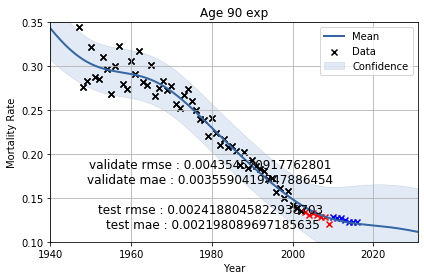

array([ 2.17074475e+10, -1.27855821e-02])

In [14]:
gp_regression(x_train, y_train, exp, (1, -0.00001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[0.03171408]


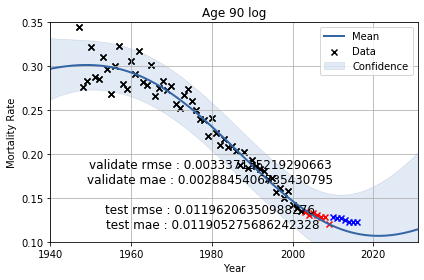

array([0.03171408])

In [15]:
gp_regression(x_train, y_train, log, (0.0001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[ 9.29793485e-07 -5.55358879e-03  1.10526328e+01 -7.32911358e+03]


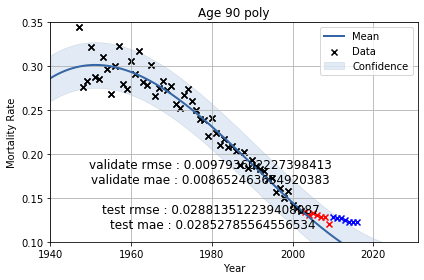

array([ 9.29793485e-07, -5.55358879e-03,  1.10526328e+01, -7.32911358e+03])

In [16]:
gp_regression(x_train, y_train, poly, (0.1, 0.1, 0.1, 0.001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[-3.23353489e-03  6.62531888e+00]


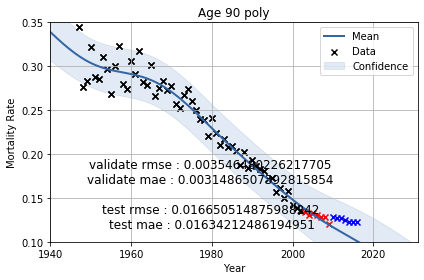

array([-3.23353489e-03,  6.62531888e+00])

In [17]:
gp_regression(x_train, y_train, poly, (0.001, 0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[8.07385382e-07 1.00000000e-03]


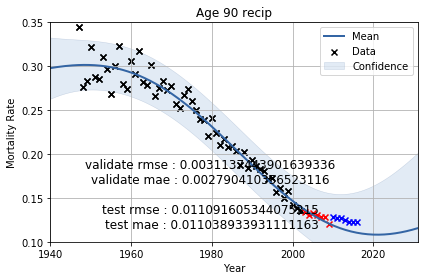

array([8.07385382e-07, 1.00000000e-03])

In [18]:
gp_regression(x_train, y_train, recip, (0.001, 0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[0.001 0.001]


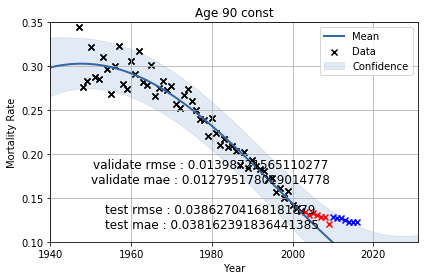

array([0.001, 0.001])

In [19]:
gp_regression(x_train, y_train, const, (0.001, 0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[-0.001 -0.001]


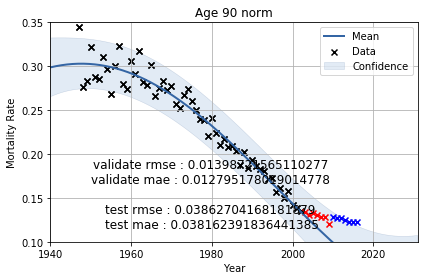

array([-0.001, -0.001])

In [20]:
gp_regression(x_train, y_train, norm, (-0.001, -0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
params:[-7.76177619e-02  1.53321150e+02]


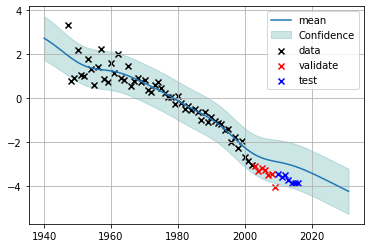

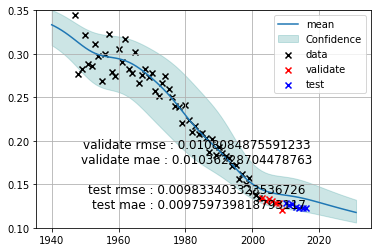

  0%|          | 1/1296 [00:00<18:55,  1.14it/s]

validate rmse : 0.0108084875591233 
 validate mae : 0.01036228704478763 

    test rmse : 0.009833403323536726 
 test mae : 0.009759739818793117
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))
params:[-7.76175683e-02  1.53320767e+02]


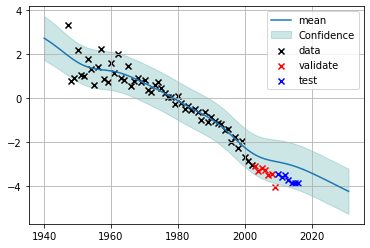

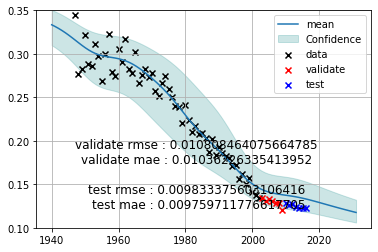

  0%|          | 2/1296 [00:01<19:25,  1.11it/s]

validate rmse : 0.010808464075664785 
 validate mae : 0.01036226335413952 

    test rmse : 0.009833375603106416 
 test mae : 0.009759711776617705
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))
params:[-1.03737470e-01  2.04867769e+02]


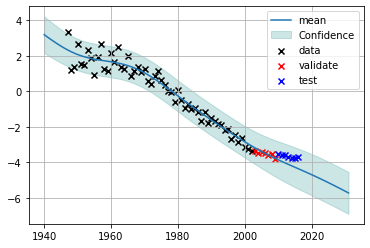

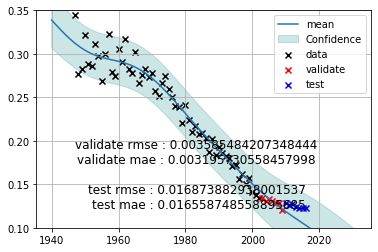

  0%|          | 3/1296 [00:04<37:48,  1.75s/it]

validate rmse : 0.003585484207348444 
 validate mae : 0.003195730558457998 

    test rmse : 0.016873882938001537 
 test mae : 0.016558748558895685
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))
params:[-1.10454657e-01  2.18090113e+02]


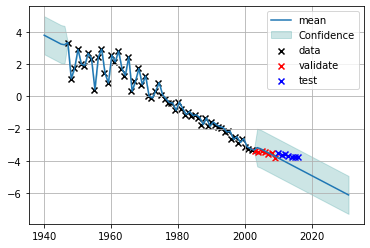

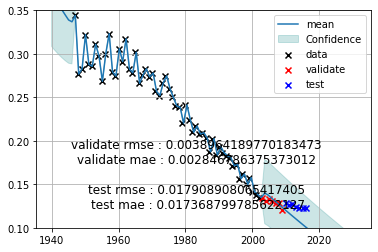

  0%|          | 4/1296 [00:10<1:15:54,  3.53s/it]

validate rmse : 0.0038964189770183473 
 validate mae : 0.002846786375373012 

    test rmse : 0.017908908065417405 
 test mae : 0.017368799785622127
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
params:[-8.17929046e-02  1.60473205e+02]


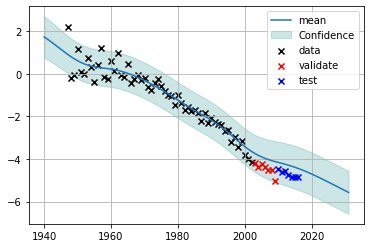

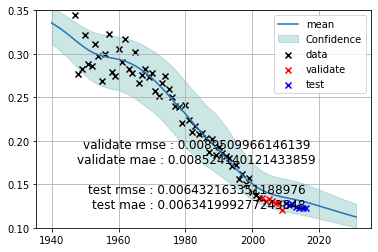

  0%|          | 5/1296 [00:11<55:09,  2.56s/it]  

validate rmse : 0.0089509966146139 
 validate mae : 0.008524140121433859 

    test rmse : 0.006432163351188976 
 test mae : 0.006341999277243848
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))
params:[-8.01066481e-02  1.55903197e+02]


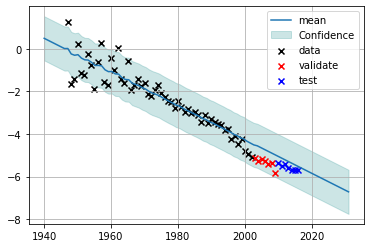

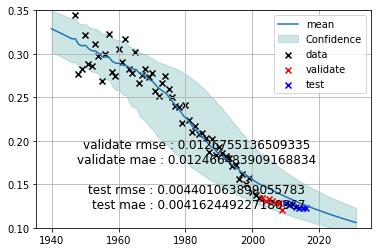

  0%|          | 6/1296 [00:12<43:32,  2.03s/it]

validate rmse : 0.0126755136509335 
 validate mae : 0.012466483909168834 

    test rmse : 0.004401063899055783 
 test mae : 0.004162449227180967
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))
params:[-7.76175705e-02  1.53320771e+02]


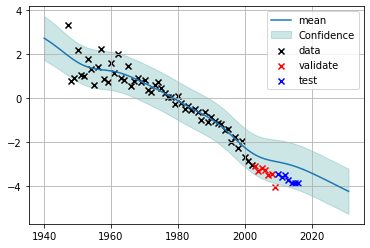

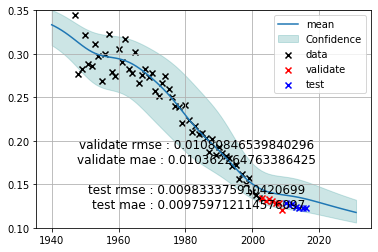

  1%|          | 7/1296 [00:13<35:36,  1.66s/it]

validate rmse : 0.01080846539840296 
 validate mae : 0.010362264763386425 

    test rmse : 0.009833375910420699 
 test mae : 0.009759712114576097
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))
params:[-7.76175735e-02  1.53320777e+02]


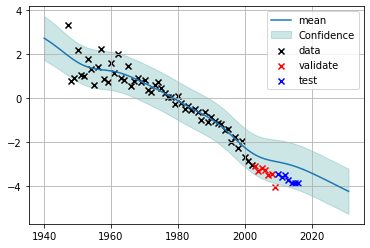

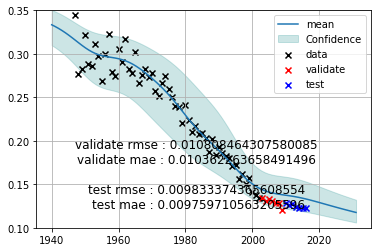

  1%|          | 8/1296 [00:14<31:13,  1.45s/it]

validate rmse : 0.010808464307580085 
 validate mae : 0.010362263658491496 

    test rmse : 0.009833374365608554 
 test mae : 0.009759710563205596
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))
params:[-1.03650952e-01  2.04674242e+02]


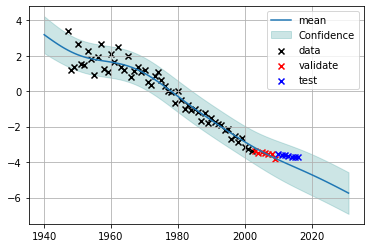

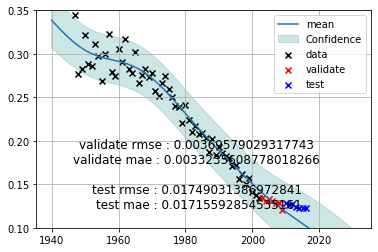

  1%|          | 9/1296 [00:16<33:03,  1.54s/it]

validate rmse : 0.00369579029317743 
 validate mae : 0.0033235608778018266 

    test rmse : 0.01749031386972841 
 test mae : 0.01715592854535161
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1.10552053e-01  2.18285338e+02]


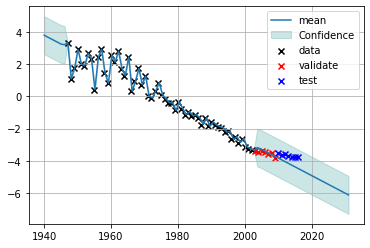

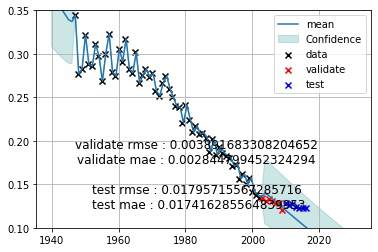

  1%|          | 10/1296 [00:28<1:44:40,  4.88s/it]

validate rmse : 0.003891683308204652 
 validate mae : 0.002844799452324294 

    test rmse : 0.01795715567285716 
 test mae : 0.017416285564839953
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))
params:[-8.17928869e-02  1.60473170e+02]


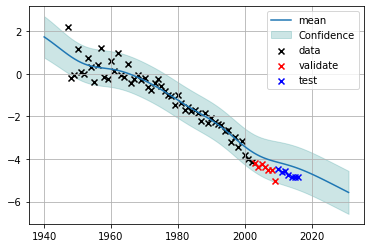

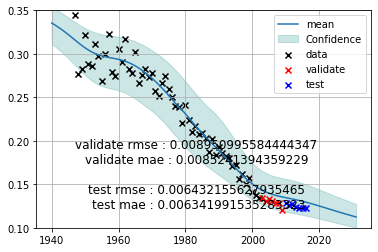

  1%|          | 11/1296 [00:29<1:17:42,  3.63s/it]

validate rmse : 0.008950995584444347 
 validate mae : 0.0085241394359229 

    test rmse : 0.006432155627935465 
 test mae : 0.006341991535283323
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))
params:[-8.01066579e-02  1.55903216e+02]


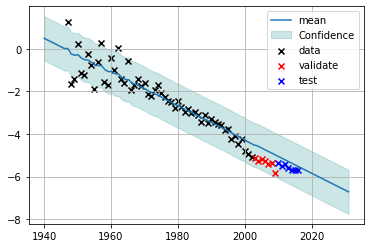

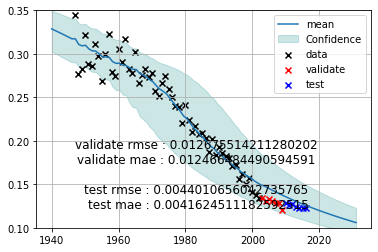

  1%|          | 12/1296 [00:30<59:44,  2.79s/it]  

validate rmse : 0.012675514211280202 
 validate mae : 0.012466484490594591 

    test rmse : 0.0044010656042735765 
 test mae : 0.0041624511182592515
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))
params:[-1.02858738e-01  2.03196975e+02]


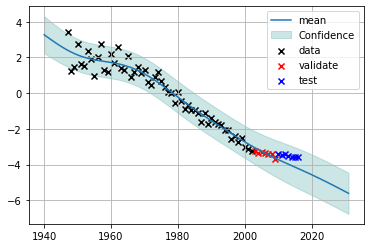

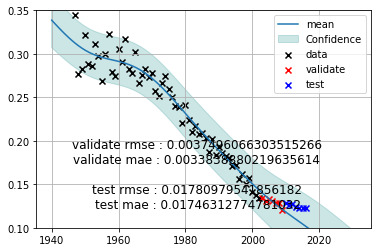

  1%|          | 13/1296 [00:32<52:49,  2.47s/it]

validate rmse : 0.0037496066303515266 
 validate mae : 0.0033838880219635614 

    test rmse : 0.01780979541856182 
 test mae : 0.01746312774781032
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 2))
params:[-1.02791455e-01  2.03052766e+02]


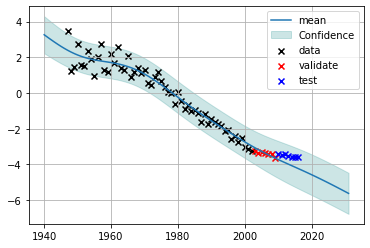

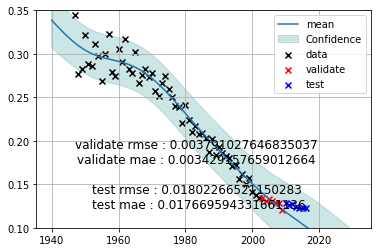

  1%|          | 14/1296 [00:33<47:42,  2.23s/it]

validate rmse : 0.003791027646835037 
 validate mae : 0.003429157659012664 

    test rmse : 0.01802266521150283 
 test mae : 0.017669594331661136
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 1))
params:[-1.06756147e-01  2.10663953e+02]


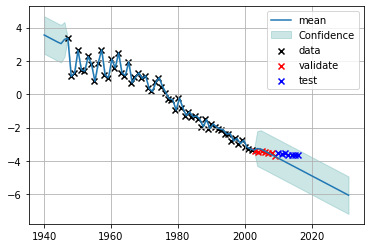

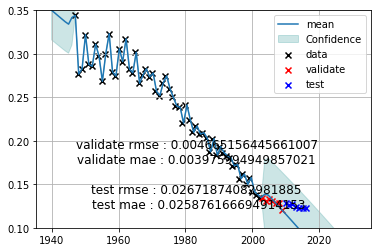

  1%|          | 15/1296 [00:36<49:11,  2.30s/it]

validate rmse : 0.004665156445661007 
 validate mae : 0.003975994949857021 

    test rmse : 0.02671874082981885 
 test mae : 0.025876166694914153
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 2))
params:[-1.12317841e-01  2.21474470e+02]


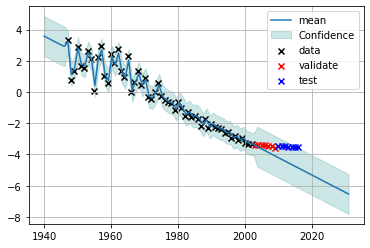

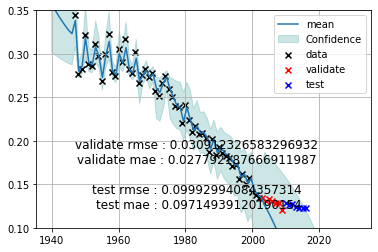

  1%|          | 16/1296 [00:43<1:18:48,  3.69s/it]

validate rmse : 0.030912326583296932 
 validate mae : 0.027792187666911987 

    test rmse : 0.09992994084357314 
 test mae : 0.09714939120190154
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 1))
params:[-1.03469534e-01  2.03336271e+02]


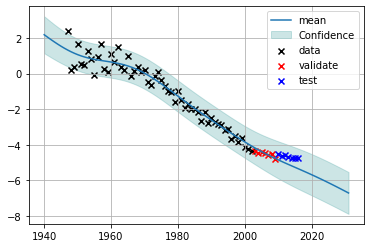

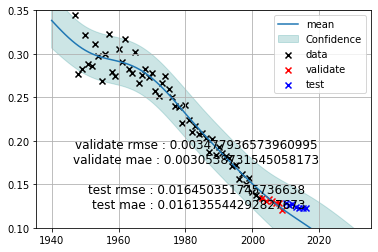

  1%|▏         | 17/1296 [00:45<1:07:08,  3.15s/it]

validate rmse : 0.003477936573960995 
 validate mae : 0.0030538731545058173 

    test rmse : 0.016450351745736638 
 test mae : 0.016135544292827673
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 2))
params:[-1.03914630e-01  2.03159139e+02]


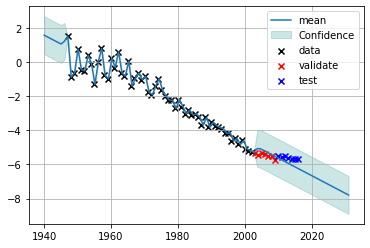

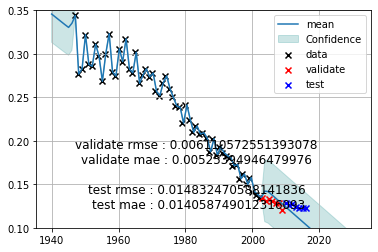

  1%|▏         | 18/1296 [00:46<59:32,  2.80s/it]  

validate rmse : 0.006110572551393078 
 validate mae : 0.00525394946479976 

    test rmse : 0.014832470588141836 
 test mae : 0.014058749012316093
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 1))
params:[-1.10320132e-01  2.17821354e+02]


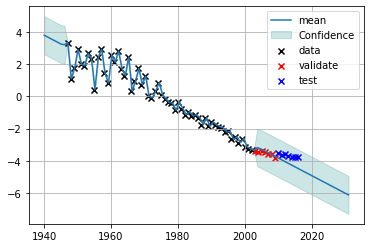

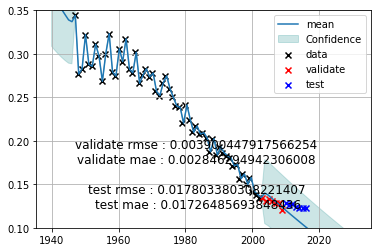

  1%|▏         | 19/1296 [00:51<1:10:14,  3.30s/it]

validate rmse : 0.003900447917566254 
 validate mae : 0.002846294942306008 

    test rmse : 0.017803380308221407 
 test mae : 0.01726485693848436
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 2))
params:[-1.10192340e-01  2.17566859e+02]


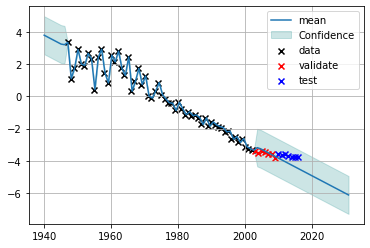

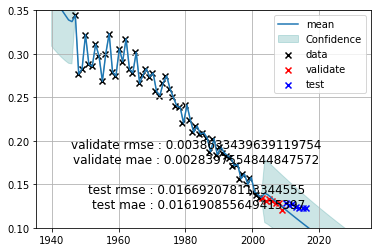

  2%|▏         | 20/1296 [00:55<1:12:38,  3.42s/it]

validate rmse : 0.0038633439639119754 
 validate mae : 0.0028397554844847572 

    test rmse : 0.016692078113344555 
 test mae : 0.016190855649415397
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 1))
params:[-1.10991573e-01  2.19157908e+02]


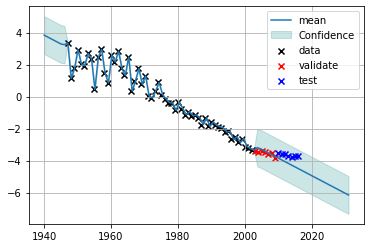

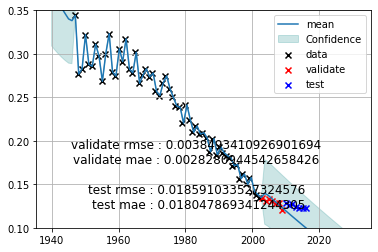

  2%|▏         | 21/1296 [01:01<1:29:43,  4.22s/it]

validate rmse : 0.0038493410926901694 
 validate mae : 0.0028280944542658426 

    test rmse : 0.018591033527324576 
 test mae : 0.018047869341244305
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 2))
params:[-1.21259885e-07  5.44804081e-01]


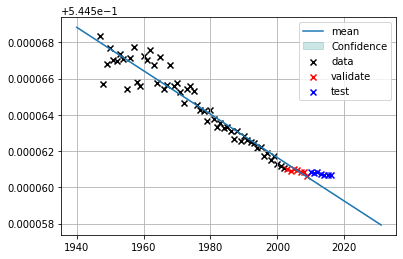

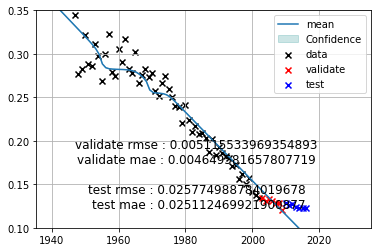

  2%|▏         | 22/1296 [01:05<1:32:15,  4.34s/it]

validate rmse : 0.005115533969354893 
 validate mae : 0.004649581657807719 

    test rmse : 0.025774988784019678 
 test mae : 0.025112469921900877
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 1))
params:[-1.09140094e-01  2.14576873e+02]


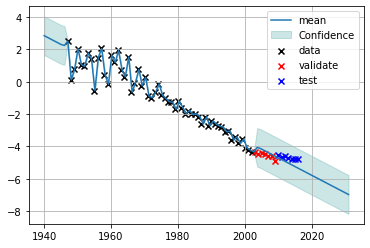

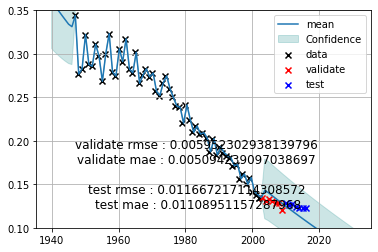

  2%|▏         | 23/1296 [01:10<1:36:58,  4.57s/it]

validate rmse : 0.005952302938139796 
 validate mae : 0.005094239097038697 

    test rmse : 0.011667217114308572 
 test mae : 0.01108951157287968
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 2))
params:[-1.09045879e-01  2.13384604e+02]


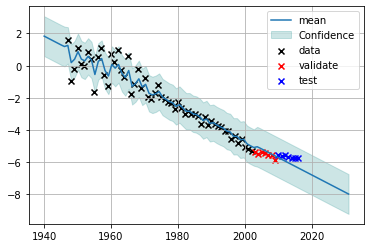

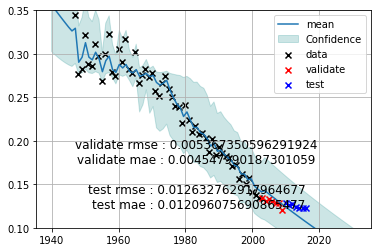

  2%|▏         | 24/1296 [01:14<1:32:31,  4.36s/it]

validate rmse : 0.005367350596291924 
 validate mae : 0.004547990187301059 

    test rmse : 0.012632762917964677 
 test mae : 0.012096075690865477
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
params:[-7.69094634e-02  1.51138773e+02]


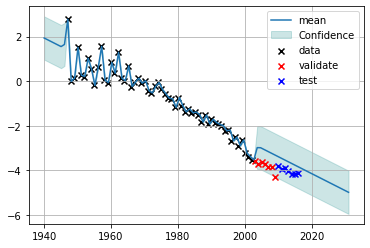

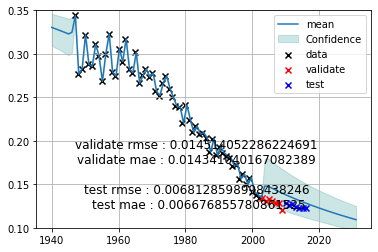

  2%|▏         | 25/1296 [01:15<1:10:39,  3.34s/it]

validate rmse : 0.014514052286224691 
 validate mae : 0.014341040167082389 

    test rmse : 0.0068128598998438246 
 test mae : 0.006676855780861525
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 2))
params:[-7.69094553e-02  1.51138757e+02]


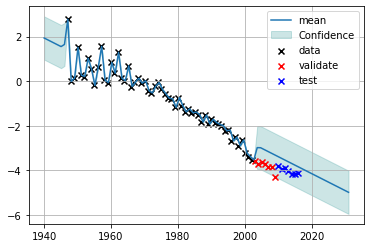

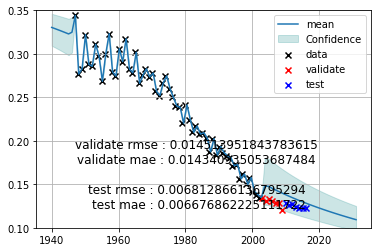

  2%|▏         | 26/1296 [01:16<55:46,  2.63s/it]  

validate rmse : 0.014513951843783615 
 validate mae : 0.014340935053687484 

    test rmse : 0.006812866136795294 
 test mae : 0.006676862225111722
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 1))
params:[-1.04271549e-01  2.05929107e+02]


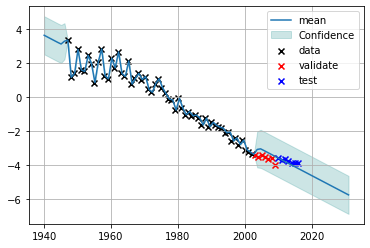

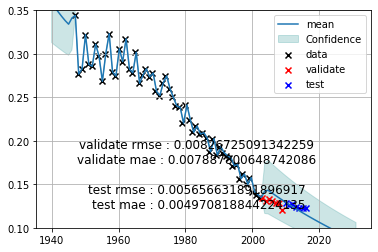

  2%|▏         | 27/1296 [01:20<1:00:13,  2.85s/it]

validate rmse : 0.00826725091342259 
 validate mae : 0.007887800648742086 

    test rmse : 0.005656631891896917 
 test mae : 0.004970818844224135
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 2))
params:[-1.09219139e-01  2.15994650e+02]


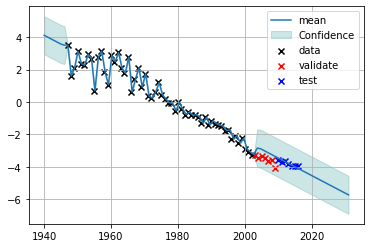

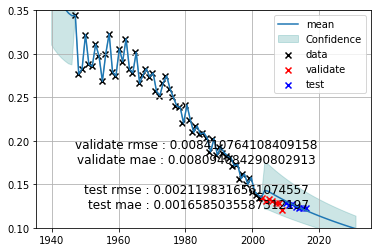

  2%|▏         | 28/1296 [01:25<1:18:11,  3.70s/it]

validate rmse : 0.008410764108409158 
 validate mae : 0.008094084290802913 

    test rmse : 0.0021198316561074557 
 test mae : 0.0016585035587312197
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
params:[-8.40445904e-02  1.63599933e+02]


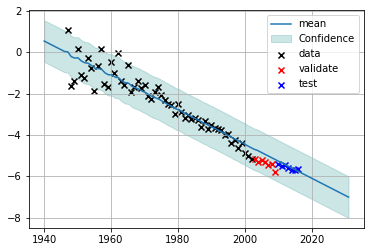

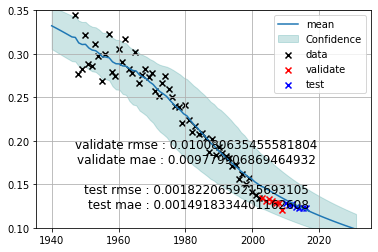

  2%|▏         | 29/1296 [01:26<59:02,  2.80s/it]  

validate rmse : 0.010080635455581804 
 validate mae : 0.009779906869464932 

    test rmse : 0.0018220659215693105 
 test mae : 0.0014918334401162608
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 2))
params:[-7.85089873e-02  1.51640557e+02]


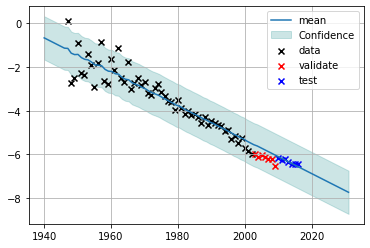

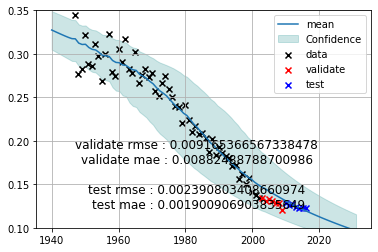

  2%|▏         | 30/1296 [01:27<45:54,  2.18s/it]

validate rmse : 0.009165366567338478 
 validate mae : 0.00882488788700986 

    test rmse : 0.002390803408660974 
 test mae : 0.001900906903835649
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 1))
params:[-7.04458662e-02  1.37511470e+02]


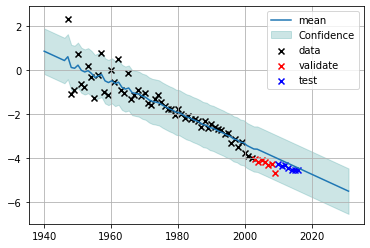

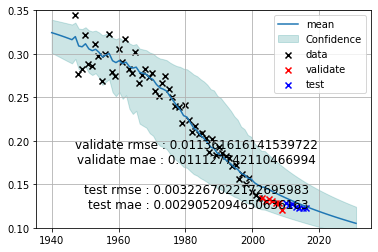

  2%|▏         | 31/1296 [01:27<36:47,  1.74s/it]

validate rmse : 0.011361616141539722 
 validate mae : 0.011127742110466994 

    test rmse : 0.0032267022172695983 
 test mae : 0.0029052094650636163
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 2))
params:[-7.04458530e-02  1.37511443e+02]


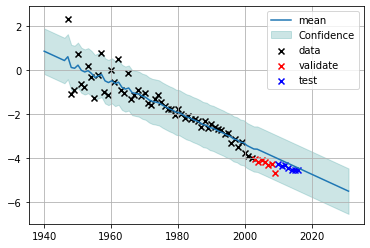

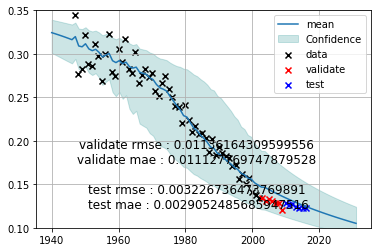

  2%|▏         | 32/1296 [01:28<30:54,  1.47s/it]

validate rmse : 0.01136164309599556 
 validate mae : 0.011127769747879528 

    test rmse : 0.003226736473769891 
 test mae : 0.0029052485685947516
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 1))
params:[-9.68252175e-02  1.91332122e+02]


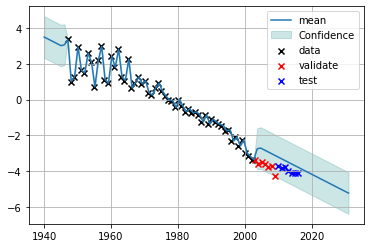

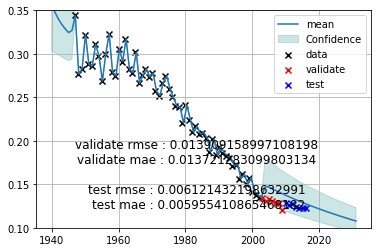

  3%|▎         | 33/1296 [01:29<28:11,  1.34s/it]

validate rmse : 0.013909158997108198 
 validate mae : 0.013721283099803134 

    test rmse : 0.006121432198632991 
 test mae : 0.005955410865468182
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 2))
params:[-1.10905305e-01  2.19143216e+02]


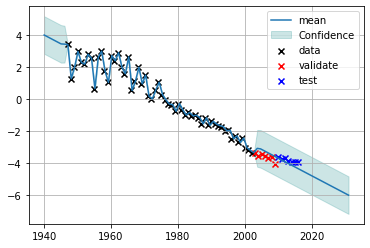

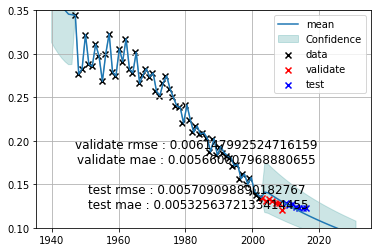

  3%|▎         | 34/1296 [01:37<1:10:58,  3.37s/it]

validate rmse : 0.006147992524716159 
 validate mae : 0.005660007968880655 

    test rmse : 0.005709098890182767 
 test mae : 0.0053256372133414455
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 1))
params:[-7.61441142e-02  1.46991598e+02]


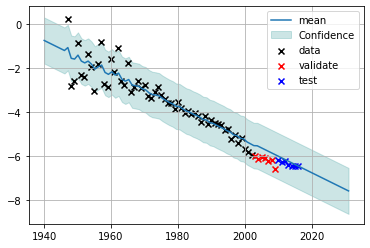

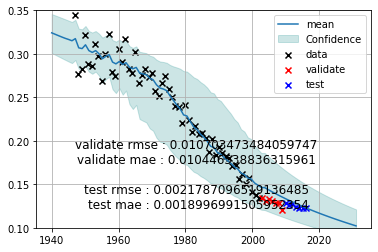

  3%|▎         | 35/1296 [01:38<54:04,  2.57s/it]  

validate rmse : 0.010703473484059747 
 validate mae : 0.010446538836315961 

    test rmse : 0.0021787096519136485 
 test mae : 0.0018996991505952354
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 2))
params:[-6.74862046e-02  1.28871720e+02]


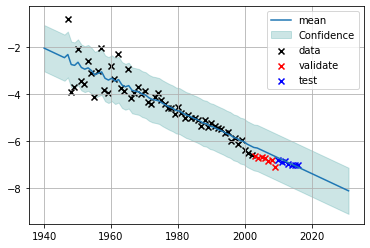

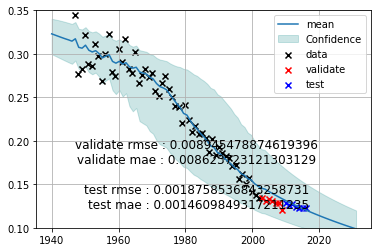

  3%|▎         | 36/1296 [01:39<44:12,  2.11s/it]

validate rmse : 0.008945478874619396 
 validate mae : 0.008623723121303129 

    test rmse : 0.0018758536843258731 
 test mae : 0.0014609849317211235
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 1))
params:[-7.76175764e-02  1.53320783e+02]


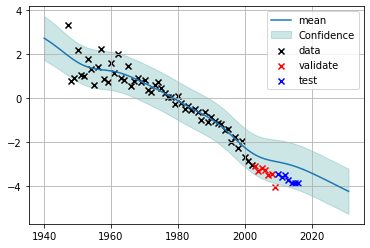

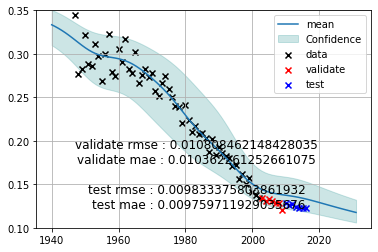

  3%|▎         | 37/1296 [01:40<36:55,  1.76s/it]

validate rmse : 0.010808462148428035 
 validate mae : 0.010362261252661075 

    test rmse : 0.009833375803861932 
 test mae : 0.009759711929035676
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 2))
params:[-7.76175765e-02  1.53320783e+02]


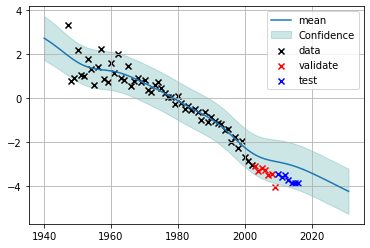

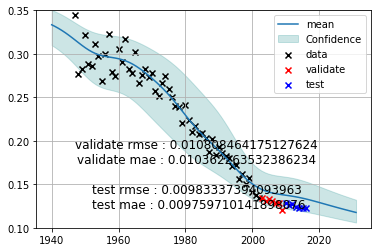

  3%|▎         | 38/1296 [01:41<31:42,  1.51s/it]

validate rmse : 0.010808464175127624 
 validate mae : 0.010362263532386234 

    test rmse : 0.00983337394093963 
 test mae : 0.009759710141898076
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 1))
params:[-1.03831879e-01  2.05061996e+02]


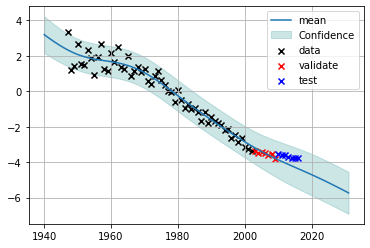

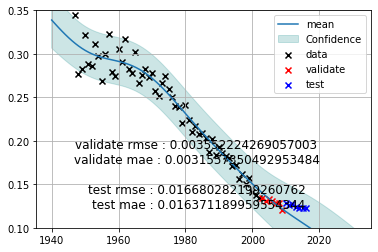

  3%|▎         | 39/1296 [01:45<48:55,  2.34s/it]

validate rmse : 0.003552224269057003 
 validate mae : 0.0031557350492953484 

    test rmse : 0.016680282199260762 
 test mae : 0.016371189959554344
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 2))
params:[-6.29372389e-02  1.25063093e+02]


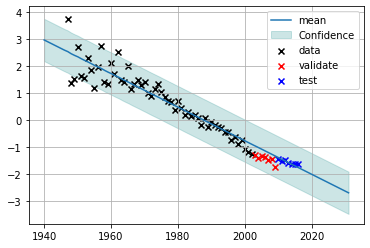

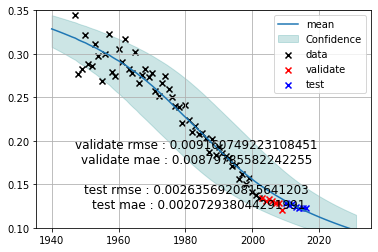

  3%|▎         | 40/1296 [01:47<43:12,  2.06s/it]

validate rmse : 0.009160749223108451 
 validate mae : 0.00879785582242255 

    test rmse : 0.0026356920815641203 
 test mae : 0.002072938044291991
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 1))
params:[-8.17928958e-02  1.60473188e+02]


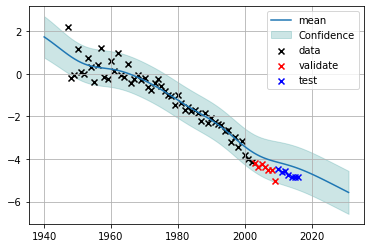

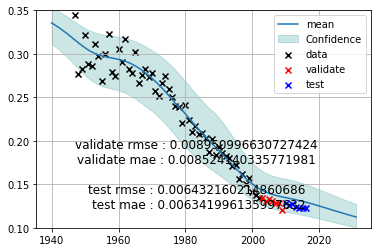

  3%|▎         | 41/1296 [01:48<35:27,  1.70s/it]

validate rmse : 0.008950996630727424 
 validate mae : 0.008524140335771981 

    test rmse : 0.006432160214860686 
 test mae : 0.006341996135997632
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 2))
params:[-8.01066841e-02  1.55903267e+02]


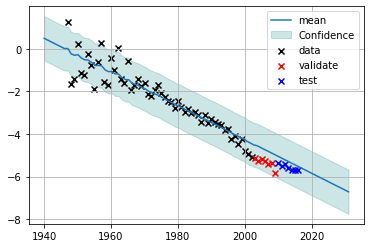

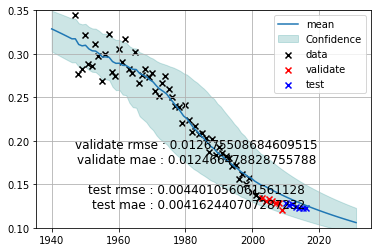

  3%|▎         | 42/1296 [01:49<31:24,  1.50s/it]

validate rmse : 0.012675508684609515 
 validate mae : 0.012466478828755788 

    test rmse : 0.004401056061561128 
 test mae : 0.004162440707287232
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 1))
params:[-7.76175636e-02  1.53320758e+02]


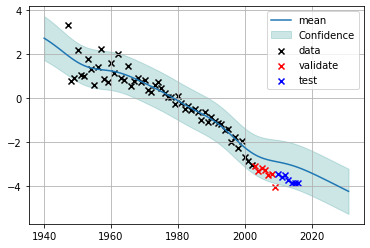

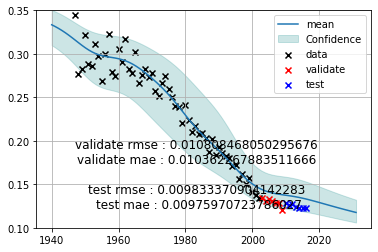

  3%|▎         | 43/1296 [01:50<29:04,  1.39s/it]

validate rmse : 0.010808468050295676 
 validate mae : 0.010362267883511666 

    test rmse : 0.009833370904142283 
 test mae : 0.00975970723786027
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 2))
params:[-7.76175884e-02  1.53320806e+02]


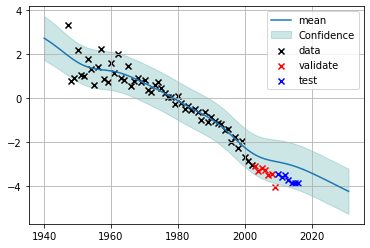

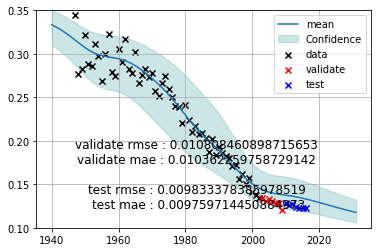

  3%|▎         | 44/1296 [01:51<26:47,  1.28s/it]

validate rmse : 0.010808460898715653 
 validate mae : 0.010362259758729142 

    test rmse : 0.009833378385978519 
 test mae : 0.009759714450884973
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 1))
params:[-1.03665611e-01  2.04709571e+02]


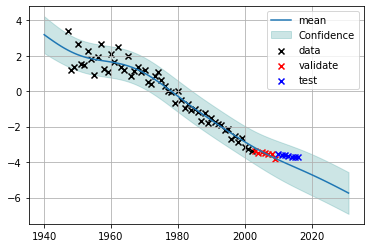

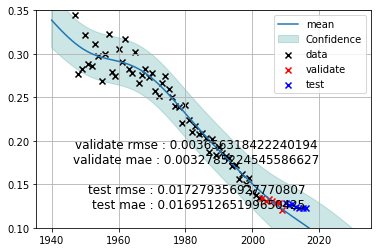

  3%|▎         | 45/1296 [01:53<31:36,  1.52s/it]

validate rmse : 0.003656318422240194 
 validate mae : 0.0032785224545586627 

    test rmse : 0.017279356927770807 
 test mae : 0.016951265199650425
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 2))
params:[-1.10451977e-01  2.18085239e+02]


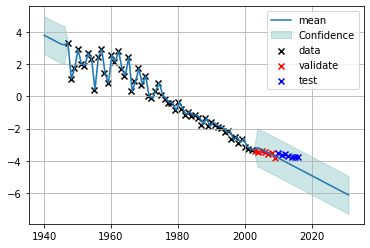

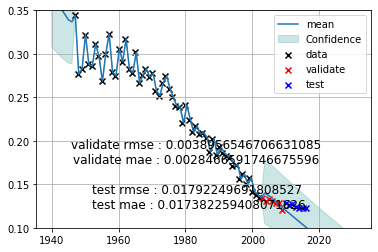

  4%|▎         | 46/1296 [01:59<1:02:06,  2.98s/it]

validate rmse : 0.0038956546706631085 
 validate mae : 0.0028466591746675596 

    test rmse : 0.01792249691808527 
 test mae : 0.017382259408071626
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 1))
params:[-8.17928943e-02  1.60473185e+02]


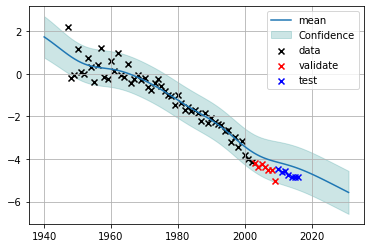

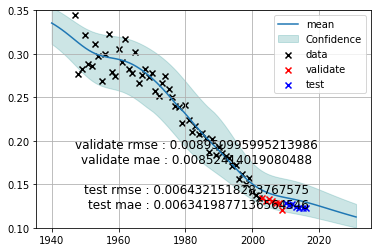

  4%|▎         | 47/1296 [02:00<49:42,  2.39s/it]  

validate rmse : 0.008950995995213986 
 validate mae : 0.00852414019080488 

    test rmse : 0.0064321518283767575 
 test mae : 0.0063419877136564546
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 2))
params:[-8.01066624e-02  1.55903224e+02]


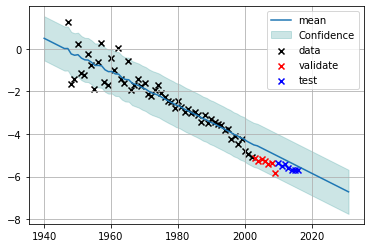

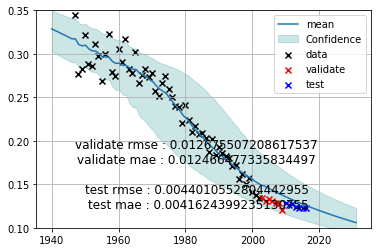

  4%|▎         | 48/1296 [02:01<41:26,  1.99s/it]

validate rmse : 0.012675507208617537 
 validate mae : 0.012466477335834497 

    test rmse : 0.0044010552804442955 
 test mae : 0.0041624399235130755
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 1))
params:[-1.03150069e-01  2.03815913e+02]


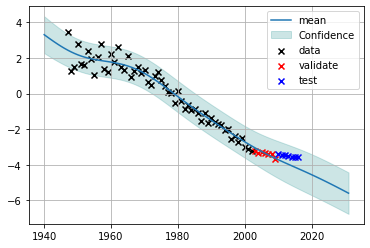

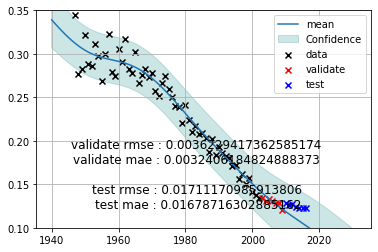

  4%|▍         | 49/1296 [02:04<45:21,  2.18s/it]

validate rmse : 0.0036229417362585174 
 validate mae : 0.0032406184824888373 

    test rmse : 0.01711170985913806 
 test mae : 0.01678716302885162
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 2))
params:[-1.02790554e-01  2.03051436e+02]


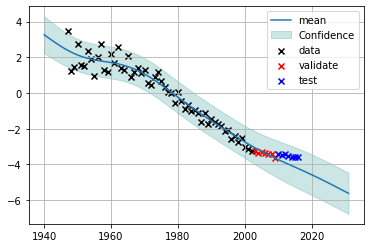

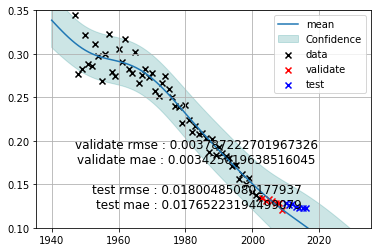

  4%|▍         | 50/1296 [02:06<44:48,  2.16s/it]

validate rmse : 0.003787222701967326 
 validate mae : 0.003425019638516045 

    test rmse : 0.01800485080177937 
 test mae : 0.01765223194499079
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 1))
params:[-1.06647123e-01  2.10449292e+02]


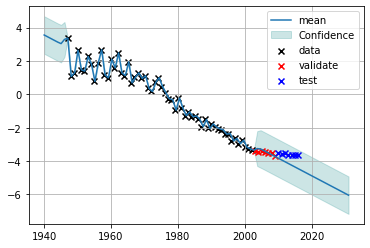

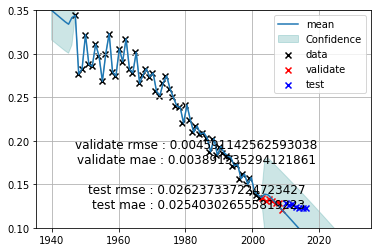

  4%|▍         | 51/1296 [02:08<46:25,  2.24s/it]

validate rmse : 0.004591142562593038 
 validate mae : 0.003891535294121861 

    test rmse : 0.026237337224723427 
 test mae : 0.025403026555819223
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2))
params:[-1.11733176e-01  2.20599483e+02]


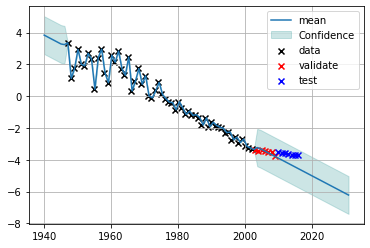

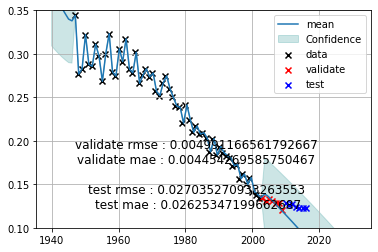

  4%|▍         | 52/1296 [02:15<1:10:08,  3.38s/it]

validate rmse : 0.004991166561792667 
 validate mae : 0.004454269585750467 

    test rmse : 0.027035270933263553 
 test mae : 0.02625347199662687
(('sa', 1), ('sa', 2), ('sal', 1), ('box_cox', 1))
params:[-1.02627559e-01  2.01737108e+02]


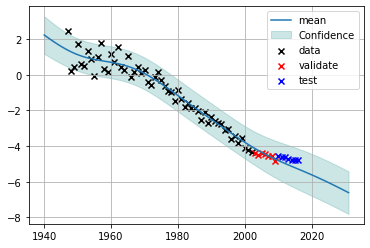

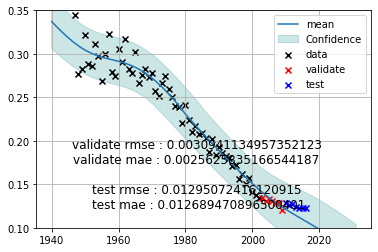

  4%|▍         | 53/1296 [02:17<1:01:19,  2.96s/it]

validate rmse : 0.0030941134957352123 
 validate mae : 0.0025625835166544187 

    test rmse : 0.01295072416120915 
 test mae : 0.012689470896500401
(('sa', 1), ('sa', 2), ('sal', 1), ('box_cox', 2))
params:[-1.04086596e-01  2.03515264e+02]


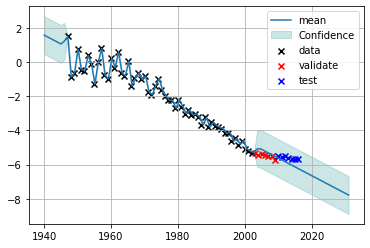

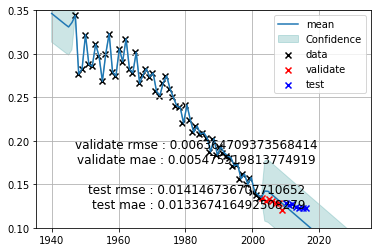

  4%|▍         | 54/1296 [02:18<54:38,  2.64s/it]  

validate rmse : 0.006364709373568414 
 validate mae : 0.005475519813774919 

    test rmse : 0.014146736707710652 
 test mae : 0.013367416492508279
(('sa', 1), ('sa', 2), ('sal', 2), ('sa', 1))
params:[-1.63947157e-01  3.23661282e+02]


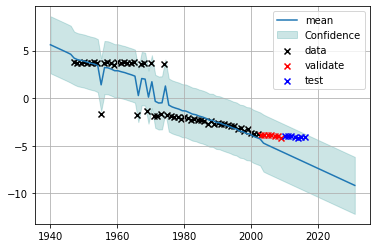

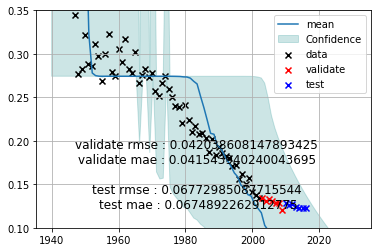

  4%|▍         | 55/1296 [02:32<2:02:51,  5.94s/it]

validate rmse : 0.042038608147893425 
 validate mae : 0.041543940240043695 

    test rmse : 0.06772985087715544 
 test mae : 0.0674892262912775
(('sa', 1), ('sa', 2), ('sal', 2), ('sa', 2))


In [ ]:
result = grid_search(cwgp_regression, x_train, y_train, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]},
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test,
                     func=poly, init_params=(1,-0.1)
                    )